In [1]:
import pickle
import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
os.environ['DGLBACKEND'] = 'pytorch'
from dgl import DGLGraph
import numpy as np
import scipy.sparse as spp
from scipy import spatial
from dgl.data import DGLDataset
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime
from ApolloScape_Dataset import ApolloScape_DGLDataset


Using backend: pytorch


In [2]:
train_dataset = ApolloScape_DGLDataset(train_val='train')
val_dataset = ApolloScape_DGLDataset(train_val='val')


In [53]:
# Collate function to prepare graphs
def collate_batch(samples):
    graphs, masks, last_vis_obj = map(list, zip(*samples))  # samples is a list of pairs (graph, mask) mask es VxTx1
    masks = np.vstack(masks)
    masks = torch.tensor(masks)#+torch.zeros(2)
    #masks = masks.view(masks.shape[0],-1)
    #masks= masks.view(masks.shape[0]*masks.shape[1],masks.shape[2],masks.shape[3])#.squeeze(0) para TAMAÑO FIJO
    sizes_n = [graph.number_of_nodes() for graph in graphs] # graph sizes
    snorm_n = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_n]
    snorm_n = torch.cat(snorm_n).sqrt()  # graph size normalization 
    sizes_e = [graph.number_of_edges() for graph in graphs] # nb of edges
    snorm_e = [torch.FloatTensor(size, 1).fill_(1 / size) for size in sizes_e]
    snorm_e = torch.cat(snorm_e).sqrt()  # graph size normalization
    batched_graph = dgl.batch(graphs)  # batch graphs
    return batched_graph.to(dev), masks.to(dev), snorm_n, snorm_e, last_vis_obj

In [54]:
dev='cuda'
train_dataloader=DataLoader(train_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)
val_dataloader=DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_batch)
batched_graph, masks, snorm_n, snorm_e, last_vis_obj=next(iter(val_dataloader))
masks.shape

torch.Size([12, 6, 1])

In [63]:
with open('../DBU_Graph/data/apollo_train_data.pkl', 'rb') as reader:
    [feat,adj, mean]=pickle.load(reader)
    
feat=np.transpose(feat, (0,3,2,1))
print(adj.shape)

(5010, 120, 120)


In [64]:
'''
#pruebas def preprocess_data de main.py (GRIP) 
feature_id = [3, 4, 9, 10]  #x,y,heading,[visible_mask]
vel_data = feat[:,feature_id]  # N,C,T,V
vel_mask = (vel_data[:, :2, 1:]!=0) * (vel_data[:, :2, :-1]!=0) #False-> frames en los que no tenemos VELOCIDAD del obj
vel_data[:, :2, 1:] = (vel_data[:, :2, 1:] - vel_data[:, :2, :-1]).astype(float) * vel_mask.astype(float)
vel_data[:, :2, 0] = 0
print(vel_data[0,:,6:,0])
#print(new_mask[0,:,:,0])
'''


'\n#pruebas def preprocess_data de main.py (GRIP) \nfeature_id = [3, 4, 9, 10]  #x,y,heading,[visible_mask]\nvel_data = feat[:,feature_id]  # N,C,T,V\nvel_mask = (vel_data[:, :2, 1:]!=0) * (vel_data[:, :2, :-1]!=0) #False-> frames en los que no tenemos VELOCIDAD del obj\nvel_data[:, :2, 1:] = (vel_data[:, :2, 1:] - vel_data[:, :2, :-1]).astype(float) * vel_mask.astype(float)\nvel_data[:, :2, 0] = 0\nprint(vel_data[0,:,6:,0])\n#print(new_mask[0,:,:,0])\n'

In [99]:

last_vis_obj_i=[]   #contains number of visible obj in each sequence of the training

for idx in range(len(adj)): 
    for i in range(len(adj[idx])): 
        if adj[idx][i,i] == 0:
            last_vis_obj_i.append(i)
            break   
            
last_vis_obj_i


[13,
 14,
 15,
 15,
 17,
 23,
 24,
 25,
 24,
 25,
 22,
 21,
 21,
 24,
 24,
 27,
 25,
 24,
 25,
 25,
 28,
 29,
 31,
 32,
 32,
 31,
 46,
 44,
 41,
 42,
 43,
 42,
 41,
 39,
 36,
 33,
 29,
 27,
 20,
 17,
 16,
 15,
 14,
 16,
 15,
 15,
 14,
 18,
 16,
 15,
 16,
 18,
 17,
 18,
 18,
 19,
 18,
 17,
 17,
 18,
 19,
 20,
 21,
 20,
 20,
 19,
 17,
 16,
 15,
 14,
 15,
 20,
 20,
 20,
 22,
 21,
 21,
 22,
 21,
 20,
 20,
 22,
 22,
 20,
 21,
 19,
 20,
 22,
 21,
 20,
 17,
 17,
 15,
 16,
 16,
 15,
 19,
 19,
 17,
 18,
 18,
 18,
 18,
 18,
 20,
 20,
 17,
 19,
 18,
 10,
 10,
 7,
 5,
 5,
 5,
 5,
 7,
 7,
 7,
 11,
 12,
 12,
 16,
 16,
 14,
 15,
 18,
 19,
 19,
 20,
 22,
 20,
 20,
 21,
 22,
 20,
 22,
 21,
 19,
 16,
 14,
 13,
 15,
 15,
 17,
 18,
 20,
 18,
 19,
 25,
 24,
 24,
 28,
 26,
 24,
 22,
 22,
 20,
 19,
 17,
 14,
 13,
 13,
 13,
 11,
 10,
 8,
 6,
 5,
 4,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 4,
 3,
 2,
 7,
 12,
 13,
 16,
 17,
 17,
 17,
 15,
 15,
 12,
 12,
 12,
 13,
 12,
 12,
 13,
 13,
 13,
 14,
 14,
 13,
 13,
 14,
 11,
 12

In [66]:
features=torch.from_numpy(feat[:,:70,:,:]).type(torch.float32)
print(features.shape)


torch.Size([5010, 70, 12, 11])


(tensor([ 0,  0,  1,  1,  2,  2,  2,  2,  3,  4,  5,  5,  5,  5,  5,  6,  6,  7,
         7,  7,  7,  7,  8,  8,  8,  9,  9,  9,  9, 10, 10, 11, 11, 11, 11, 12,
        12, 12, 12]), tensor([ 0,  6,  1,  2,  1,  2,  8,  9,  3,  4,  5,  7,  9, 11, 12,  0,  6,  5,
         7, 10, 11, 12,  2,  8,  9,  2,  5,  8,  9,  7, 10,  5,  7, 11, 12,  5,
         7, 11, 12]))


<IPython.core.display.Javascript object>


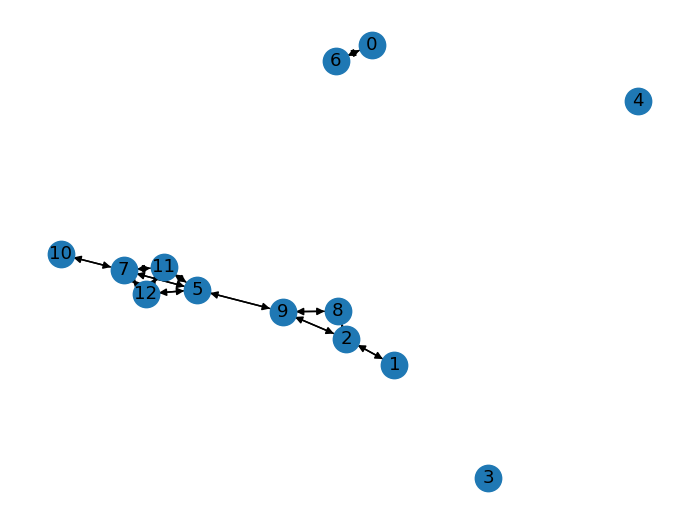

In [10]:
%matplotlib notebook
graph=dgl.DGLGraph(spp.coo_matrix(adj[0][:13,:13]))
print(graph.edges())
nx.draw(graph.to_networkx(), with_labels=True)
plt.show()

<IPython.core.display.Javascript object>


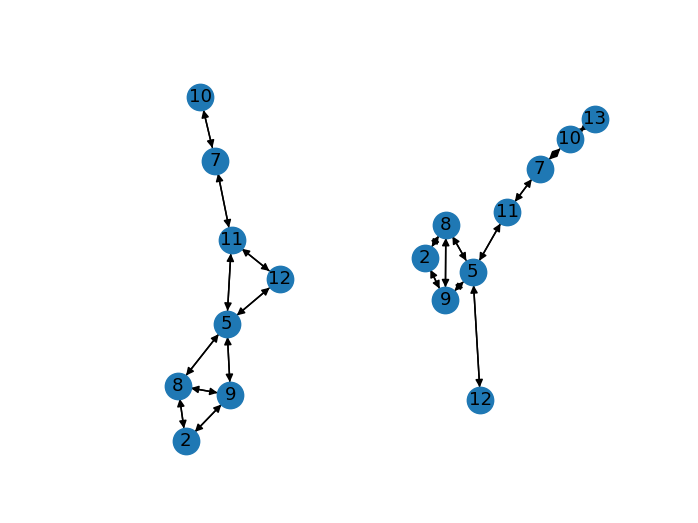

In [12]:
%matplotlib notebook

plt.subplot(1,2,1)
graph=dgl.DGLGraph(spp.coo_matrix(adj[1][:last_vis_obj[1],:last_vis_obj[1]]))
nx.draw(graph.to_networkx(), with_labels=True)
plt.subplot(1,2,2)
graph=dgl.DGLGraph(spp.coo_matrix(adj[2][:last_vis_obj[2],:last_vis_obj[2]]))
nx.draw(graph.to_networkx(), with_labels=True)
plt.show()

### PREPROCESS DATA

### Crear grafo (Ejemplo secuencia 0)
Para el entrenamiento iterar sobre todas las secuencias

In [67]:
now_history_frame=6
object_type = features[:,:,:,2].int()  # torch Tensor NxVxT
#vis_obj_type=np.zeros((features.shape[0],features.shape[1])) #NxV
mask_car=np.zeros((features.shape[0],features.shape[1],now_history_frame)) #NxVx6
for i in range(len(features)):
    #vis_obj_type[i,:] =object_type[i,:,5] #Append Vx1 #tipos de obj visibles de la primera seq    
    mask_car_t=np.array([1  if (j==2 or j==1) else 0 for j in object_type[i,:,5]])  #1 si obj 1/2 en frame 5 (size V)
    mask_car[i,:]=np.array(mask_car_t).reshape(mask_car.shape[1],1)+np.zeros(6) #Vx6 mask para los 6 output frames que indican si el obj es visible y car

#COMPROBADO OK

In [68]:

feature_id = [3, 4, 9]  #x,y,heading,[visible_mask]
#120 agentes (13 visibles -> feat[11]=1) y 12 frames (si no hay info en alguno de os 12 frames: fila nula)
node_features = features[:,:,:now_history_frame,feature_id]  #obj type,x,y 6 primeros frames
node_labels=features[:,:,now_history_frame:,3:5] #x,y 6 ultimos frames
node_features[:,:,:,-1] *= mask_car   #Pongo 0 en feat 11 [mask] a todos los obj visibles no-car
node_labels[:,:,:,-1] *= mask_car
output_mask= features[:,:,6:,-1]*mask_car #mascara obj (car) visibles en 6º frame (5010,120,6)
output_mask.unsqueeze_(-1).type(torch.uint8)    #N,V,T,1                  

print(node_features.shape, node_labels.shape,output_mask.shape)

torch.Size([5010, 70, 6, 3]) torch.Size([5010, 70, 6, 2]) torch.Size([5010, 70, 6, 1])


In [69]:
zero_indeces_list = [i for i in range(len(output_mask)) if np.all(np.array(output_mask.squeeze(-1))==0, axis=(1,2))[i] == True ]
zero_indeces_list

[51,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 256,
 257,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 275,
 276,
 277,
 278,
 279,
 280,
 281,
 282,
 283,
 284,
 285,
 286,
 288,
 289,
 290,
 298,
 299,
 300,
 301,
 311,
 312,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 326,
 327,
 328,
 329,
 330,
 331,
 332,
 333,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348,
 349,
 350,
 351,
 352,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 363,
 364,
 365,
 366,
 1104,
 1105,
 1106,
 1107,
 1108,
 1109,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1118,
 1119,
 1191,
 1192,
 1193,
 1194,
 1195,
 1196,
 1197,
 1198,
 1199,
 1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1212,
 1213,
 1214,
 1215,
 1216,
 1217,
 1218,
 1219,
 1220,
 1221,
 1222,
 1223,
 1224,
 1225,
 1226,
 1227,
 1231,
 1232,
 1233,
 1244,
 1245,
 1246,
 1247,
 1248,
 1249,
 1270,
 1

In [70]:
zero_maskcar_list = [i for i in range(len(mask_car)) if np.all(np.array(mask_car)==0, axis=(1,2))[i] == True ]
len(zero_maskcar_list) #374

374

In [71]:
total_num = len(features)
id_list = list(set(list(range(total_num))) - set(zero_indeces_list))
total_valid_num = len(id_list) #4596
ind=np.random.permutation(id_list)
train_id_list, val_id_list = ind[:round(total_valid_num*0.8)], ind[round(total_valid_num*0.8):]


'''
train_id_list = list(np.linspace(0, total_valid_num-1, int(total_valid_num*0.8)).astype(int))
val_id_list = list(set(list(range(total_valid_num))) - set(train_id_list))  

if train_val_test.lower() == 'train':
    self.all_feature = self.all_feature[train_id_list]
    self.all_adjacency = self.all_adjacency[train_id_list]
    self.all_mean_xy = self.all_mean_xy[train_id_list]
elif train_val_test.lower() == 'val':
    self.all_feature = self.all_feature[val_id_list]
    self.all_adjacency = self.all_adjacency[val_id_list]
    self.all_mean_xy = self.all_mean_xy[val_id_list]
'''
print(len(train_id_list)) #3677

3677


In [72]:
xy_dist=[spatial.distance.cdist(node_features[i][:,5,:], node_features[i][:,5,:]) for i in range(len(features))]  #5010x120x120

In [ ]:
####PESOS EN EDGES
#120x120 -> solo quiero los que tengan 1 en Adj[0] (máscara) aka 39 valores
#Obtener las 39 distancias correspondientes a cada edge
distances = [xy_dist[0][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
print(len(distances))
norm_distances = [(i-min(distances))/(max(distances)-min(distances)) for i in distances]
norm_distances = [1/(i) if i!=0 else 1 for i in distances]
print(norm_distances)
#NORMALIZAR ENTRE 0 Y 1
graph.edata['w']=torch.tensor(norm_distances, dtype=torch.float32)

### Convolutional Layer 

In [5]:
import dgl.function as fn
#Perform message passing and then apply fc Layer (self-loops! - same W for neighbors and itself)
# Traditional GCN:
#fn.copy_src(src='h', out='m')
#gcn_reduce = fn.sum(msg='m', out='h')
# multiply source node features with edge weights and aggregate them in destination nodes
gcn_msg=fn.u_mul_e('h', 'w', 'm') #elemnt-wise (broadcast)
gcn_reduce = fn.sum(msg='m', out='h')
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear_self = nn.Linear(in_feats, out_feats, bias=False)
        self.linear = nn.Linear(in_feats, out_feats)
        
    def reduce_func(self, nodes):
        h = torch.sum(nodes.mailbox['m'], dim=1)
        return {'h': h}

    def forward(self, g, feature,e_w, snorm_n, snorm_e):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            
            g.ndata['h_s']=self.linear_self(feature)
            
            #normalization
            degs = g.out_degrees().float().clamp(min=1)
            norm=torch.pow(degs,-0.5)
            shp = norm.shape + (1,)*(feature.dim() -1)
            norm = torch.reshape(norm,shp)
            feature = feature*norm
            
            #aggregate
            g.edata['w'] = e_w
            g.ndata['h'] = feature
            g.update_all(gcn_msg, self.reduce_func)
            
            #mult W and normalization
            h = self.linear(g.ndata['h'])
            degs = g.in_degrees().float().clamp(min=1)
            norm = torch.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feature.dim() - 1)
            norm = torch.reshape(norm, shp)
            h = h * norm
            
            h = g.ndata['h_s'] + h #Vx6xout_feats
            
            #h = h * (torch.ones_like(h)*snorm_n)  # normalize activation w.r.t. graph node size
            #e_w =  e_w * (torch.ones_like(e_w)*snorm_e)  # normalize activation w.r.t. graph edge size
            e_w =  e_w
            
            return h, e_w

In [6]:
#Prueba forward pass en gcn con un grafo OK
#model = GCN(in_feats=4, hid_feats=64, out_feats=2)
#model(graph, graph.ndata['x'],graph.edata['w'])

In [29]:
from dgl.nn import GatedGraphConv, GraphConv, GATConv,SAGEConv

conv = GraphConv(4,2, weight=True, bias=True)
#sageconv = SAGEConv(4,2,aggregator_type='lstm')
#gated_conv = GatedGraphConv(4, 2, 2, 3)
#gatconv=GATConv(4,2,num_heads=4)
graph = dgl.add_self_loop(graph)   #Añado selfloops pq no puede haber zero in-degree nodes
res = conv(graph, node_features[0])
print(res.shape)

torch.Size([70, 6, 2])


### Graph Convolutional Model

In [7]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = GCNLayer(in_feats=in_feats, out_feats=hid_feats)
        self.conv2 = GCNLayer(in_feats=hid_feats, out_feats=out_feats)
        self.fc= nn.Linear(out_feats,out_feats)
    def forward(self, graph, inputs,e_w,snorm_n, snorm_e):
        #inputs are features of nodes
        h,e_w = self.conv1(graph, inputs,e_w,snorm_n, snorm_e) #Vx6x4 -> Vx6x32  
        h = F.relu(h)
        h,_ = self.conv2(graph,h,e_w,snorm_n, snorm_e)  #Vx6x2  
        y = self.fc(h)
        return y
        

### GAT Layer

In [132]:
class My_GATLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(My_GATLayer, self).__init__()
        self.linear_self = nn.Linear(in_feats, out_feats, bias=False)
        self.linear_func = nn.Linear(in_feats, out_feats, bias=False)
        self.attention_func = nn.Linear(2 * out_feats, 1, bias=False)
        
    def edge_attention(self, edges):
        concat_z = torch.cat([edges.src['z'], edges.dst['z']], dim=-1) #(n_edg,6*64)||(n_edg,6*64) -> (n_edg,2*6*64) 
        src_e = self.attention_func(concat_z)  #(n_edg, 1) att logit
        src_e = F.leaky_relu(src_e)
        return {'e': src_e}
    
    def message_func(self, edges):
        return {'z': edges.src['z'], 'e':edges.data['e']}
        
    def reduce_func(self, nodes):
        h_s = nodes.data['h_s']
        a = F.softmax(nodes.mailbox['e'], dim=1)   #attention score between nodes i and j
        h = h_s + torch.sum(a * nodes.mailbox['z'], dim=1)
        return {'h': h}
                               
    def forward(self, g, h):
        with g.local_scope():
            h_in = h
            g.ndata['h']  = h 
            g.ndata['h_s'] = self.linear_self(h) 
            g.ndata['z'] = self.linear_func(h) #(18) -> (18) 
            g.apply_edges(self.edge_attention)
            g.update_all(self.message_func, self.reduce_func)
            h = g.ndata['h'] # result of graph convolution
            #h = h * snorm_n # normalize activation w.r.t. graph node size
            #h = self.bn_node_h(h) # batch normalization 
            h = torch.relu(h) # non-linear activation
            h = h_in + h # residual connection
            return h #graph.ndata.pop('h')


class MultiHeadGATLayer(nn.Module):
    def __init__(self, in_feats, out_feats, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(My_GATLayer(in_dim, out_dim))
        self.merge = merge

    def forward(self, g, h):
        head_outs = [attn_head(g, h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1), for intermediate layers
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average, for final layer
            return torch.mean(torch.stack(head_outs))

In [9]:
class MLP_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, input_dim) 
        self.layer2 = nn.Linear(input_dim, output_dim) 
        
    def forward(self, x):
        y = x
        y = self.FC_layers[l](y)
        y = torch.relu(y)
        y = self.FC_layers[self.L](y)
        return y

In [10]:
class My_GAT(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.gat_1 = My_GATLayer(hidden_dim, hidden_dim)
        self.gat_2 = My_GATLayer(hidden_dim, hidden_dim)
        #self.gat_1 = MultiHeadGATLayer(hidden_dim, hidden_dim, heads)
        #self.gat_2 = MultiHeadGATLayer(hidden_dim*heads, hidden_dim, 1)
        self.linear1 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, g, h,e_w,snorm_n,snorm_e):
        
        # input embedding
        h = self.embedding_h(h)  #input (70, 6,4) - (70, 6,32) checked
        # gat layers
        h = F.relu(self.gat_1(g, h))
        h = F.relu(self.gat_2(g, h))
        
        y = self.linear1(h)  # (6,32) -> (6,2)
        
        return y

### Gated GCN 
$$
\def \vx {\boldsymbol{\color{Plum}{x}}}
\def \vh {\boldsymbol{\color{YellowGreen}{h}}}
\def \ve {\boldsymbol{\color{purple}{e}}}
\def \aqua#1{\color{Aquamarine}{#1}}
\def \red#1{\color{OrangeRed}{#1}}
$$

In [10]:
class GatedGCN_layer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.A = nn.Linear(input_dim, output_dim)
        self.B = nn.Linear(input_dim, output_dim)
        self.C = nn.Linear(input_dim, output_dim)
        self.D = nn.Linear(input_dim, output_dim)
        self.E = nn.Linear(input_dim, output_dim)
        self.bn_node_h = nn.BatchNorm1d(output_dim)
        self.bn_node_e = nn.BatchNorm1d(output_dim)

    def message_func(self, edges):
        Bh_j = edges.src['Bh']
        # e_ij = Ce_ij + Dhi + Ehj
        e_ij = edges.data['Ce'] + edges.src['Dh'] + edges.dst['Eh']
        edges.data['e'] = e_ij
        return {'Bh_j' : Bh_j, 'e_ij' : e_ij}

    def reduce_func(self, nodes):
        Ah_i = nodes.data['Ah']
        Bh_j = nodes.mailbox['Bh_j']
        e = nodes.mailbox['e_ij']
        # sigma_ij = sigmoid(e_ij)
        sigma_ij = torch.sigmoid(e)
        # hi = Ahi + sum_j eta_ij * Bhj
        h = Ah_i + torch.sum(sigma_ij * Bh_j, dim=1) / torch.sum(sigma_ij, dim=1)
        return {'h' : h}
    
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        h_in = h # residual connection
        e_in = e # residual connection
        
        g.ndata['h']  = h 
        g.ndata['Ah'] = self.A(h) 
        g.ndata['Bh'] = self.B(h) 
        g.ndata['Dh'] = self.D(h)
        g.ndata['Eh'] = self.E(h) 
        g.edata['e']  = e 
        g.edata['Ce'] = self.C(e)
        
        g.update_all(self.message_func, self.reduce_func)
        
        h = g.ndata['h'] # result of graph convolution
        e = g.edata['e'] # result of graph convolution
        
        h = h * snorm_n # normalize activation w.r.t. graph node size
        e = e * snorm_e # normalize activation w.r.t. graph edge size
        
        h = self.bn_node_h(h) # batch normalization  
        e = self.bn_node_e(e) # batch normalization  
        
        h = torch.relu(h) # non-linear activation
        e = torch.relu(e) # non-linear activation
        
        h = h_in + h # residual connection
        e = e_in + e # residual connection
        
        return h, e

In [11]:
class GatedGCN(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, L):
        super().__init__()
        self.embedding_h = nn.Linear(input_dim, hidden_dim)
        self.embedding_e = nn.Linear(1, hidden_dim)
        self.GatedGCN_layers = nn.ModuleList([
            GatedGCN_layer(hidden_dim, hidden_dim) for _ in range(L)
        ])
        self.MLP_layer = MLP_layer(hidden_dim, output_dim)
        
    def forward(self, g, h, e, snorm_n, snorm_e):
        
        # input embedding
        h = self.embedding_h(h)
        e = self.embedding_e(e)
        
        # graph convnet layers
        for GGCN_layer in self.GatedGCN_layers:
            h, e = GGCN_layer(g, h, e, snorm_n, snorm_e)
        
        # MLP 
        y = self.MLP_layer(h)
        
        return y

### TRAINING Tests

#### Collate function to prepare graphs

In [86]:
def compute_RMSE_batch(pred, gt, mask): 
    #output mask vale 0 si no visible o no-car o visible pero no hay datos en ese frame  (B*V,T,1), cada fila un nodo de un grafo perteneciente al batch
    pred=pred.view(pred.shape[0],6,-1)
    #gt=gt.view(pred.shape[0],6,-1)
    
    pred = pred*mask #B*V,T,C  (B n grafos en el batch)
    gt = gt*mask  # outputmask BV,T,C
    
    x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=-1) # x^2+y^2 BV,T
    overall_sum_time = x2y2_error.sum(dim=-2)  #T - suma de los errores (x^2+y^2) de los V agentes
    overall_num = mask.sum(dim=-1).type(torch.int)  #torch.Tensor[(T)] - num de agentes (Y CON DATOS) en cada frame
    return overall_sum_time, overall_num, x2y2_error



In [58]:
# Collate function to prepare graphs
def collate(graph):
    snorm_n = (1 / graph.number_of_nodes())**0.5  # graph size normalization 
    snorm_e = (1 / graph.number_of_edges())**0.5 # graph size normalization
    norm_d = torch.pow(graph.in_degrees().float(),-0.5)
    norm_d[torch.isinf(norm_d)]=0  #size [n_nodes]
    return snorm_n, snorm_e, norm_d

In [142]:
from tqdm import tqdm

dev='cuda'
#model = GCN(in_feats=18, hid_feats=128, out_feats=12).to(dev)
model = My_GAT(input_dim=18, hidden_dim=128, output_dim=12).to(dev)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
np.seterr(all='raise')
train_loss_sum=[]
val_loss_sum=[]
for epoch in range(30):
    print('Epoch: ',epoch)
    overall_loss_train=[]
    overall_loss_val=[]
    model.train()
    for batched_graph, output_masks,snorm_n, snorm_e,last_vis_obj in tqdm(train_dataloader):
        feats = batched_graph.ndata['x'].float().to(dev)
        #reshape to have shape (B*V,T*C) [c1,c2,...,c6]
        feats = feats.view(feats.shape[0],-1)
        e_w = batched_graph.edata['w'].float().to(dev)
        labels= batched_graph.ndata['gt'].float().to(dev)
        #labels = labels.view(labels.shape[0], -1)
        pred = model(batched_graph, feats,e_w,snorm_n,snorm_e)   #70,6,2
        overall_sum_time, overall_num, _ = compute_RMSE_batch(pred, labels, output_masks)  #(B,6)
        total_loss=torch.sum(overall_sum_time)/torch.sum(overall_num.sum(dim=-2))
        opt.zero_grad() 
        total_loss.backward()
        opt.step()
        overall_loss_train.extend([total_loss.data.item()])
       
    #print('|{}| Train_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_train) + [np.sum(overall_loss_train)]])))
    print('|{}| Train_loss: {}'.format(datetime.now(), np.sum(overall_loss_train)/len(overall_loss_train)))
    train_loss_sum.append(np.sum(overall_loss_train)/len(overall_loss_train))
    model.eval()
    with torch.no_grad():
        overall_num_list=[] 
        overall_x2y2_list=[]
        for batched_graph, output_masks,snorm_n, snorm_e,last_vis_obj in tqdm(val_dataloader):
            feats = batched_graph.ndata['x'].float().to(dev)
            #reshape to have shape (B*V,T*C) [c1,c2,...,c6]
            feats = feats.view(feats.shape[0],-1)
            e_w = batched_graph.edata['w'].float().to(dev)
            labels= batched_graph.ndata['gt'].float().to(dev)
            #labels = labels.view(labels.shape[0], -1)
            pred = model(batched_graph, feats,e_w,snorm_n,snorm_e)
            _, overall_num, x2y2_error = compute_RMSE_batch(pred, labels, output_masks)
            #print(x2y2_error.shape)  #BV,T
            overall_num_list.extend(overall_num.detach().cpu().numpy())
            #print(overall_num.shape)  #BV,T
            overall_x2y2_list.extend((x2y2_error**0.5).detach().cpu().numpy())
            
    overall_sum_time=np.sum(overall_x2y2_list,axis=0)  #BV,T->T
    overall_num_time =np.sum(overall_num_list, axis=0)
    overall_loss_time=(overall_sum_time / overall_num_time) #media del error de cada agente en cada frame

    print('|{}| Val_loss: {}'.format(datetime.now(), ' '.join(['{:.3f}'.format(x) for x in list(overall_loss_time) + [np.sum(overall_loss_time)]])))
    val_loss_sum.append(np.sum(overall_loss_time))


  0%|          | 0/58 [00:00<?, ?it/s]

Epoch:  0


  1%|          | 9/919 [00:00<00:12, 74.11it/s]

|2020-11-12 17:49:47.619462| Train_loss: 227.35752336744412


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:50:02.797175| Val_loss: 3.153 4.750 6.718 8.619 10.433 12.290 45.964
Epoch:  1


  1%|          | 7/919 [00:00<00:14, 62.61it/s]

|2020-11-12 17:50:21.294037| Train_loss: 101.35247089150538


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:50:38.904547| Val_loss: 2.706 4.168 5.842 7.273 9.101 10.854 39.943
Epoch:  2


  1%|          | 6/919 [00:00<00:15, 59.46it/s]

|2020-11-12 17:50:57.535407| Train_loss: 78.44716816080462


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:51:13.695798| Val_loss: 2.248 3.450 4.843 6.008 7.620 9.217 33.384
Epoch:  3


  1%|          | 6/919 [00:00<00:16, 55.98it/s]

|2020-11-12 17:51:31.522718| Train_loss: 60.96120224999155


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:51:47.519473| Val_loss: 2.181 3.128 4.261 5.341 6.486 7.852 29.249
Epoch:  4


  1%|          | 8/919 [00:00<00:11, 78.08it/s]

|2020-11-12 17:52:05.612895| Train_loss: 50.432284925565924


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:52:20.340976| Val_loss: 2.071 2.964 3.992 5.031 6.003 7.204 27.265
Epoch:  5


  1%|          | 8/919 [00:00<00:11, 79.85it/s]

|2020-11-12 17:52:37.839565| Train_loss: 44.71824755554992


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:52:51.579224| Val_loss: 1.942 2.850 3.792 4.875 5.847 6.979 26.285
Epoch:  6


  1%|          | 9/919 [00:00<00:11, 78.52it/s]

|2020-11-12 17:53:08.741667| Train_loss: 41.574034178415765


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:53:22.590572| Val_loss: 1.892 2.888 3.802 4.922 5.784 6.941 26.229
Epoch:  7


  1%|          | 9/919 [00:00<00:10, 85.50it/s]

|2020-11-12 17:53:39.851108| Train_loss: 39.38911940963187


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:53:53.576543| Val_loss: 1.835 2.786 3.713 4.795 5.694 6.827 25.649
Epoch:  8


  1%|          | 9/919 [00:00<00:10, 84.39it/s]

|2020-11-12 17:54:10.765750| Train_loss: 37.70615809269101


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:54:24.578000| Val_loss: 1.805 2.712 3.621 4.691 5.534 6.652 25.015
Epoch:  9


  1%|          | 9/919 [00:00<00:11, 79.44it/s]

|2020-11-12 17:54:41.652179| Train_loss: 36.148379467658415


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:54:55.765599| Val_loss: 1.770 2.613 3.505 4.537 5.398 6.457 24.279
Epoch:  10


  1%|          | 9/919 [00:00<00:12, 71.20it/s]

|2020-11-12 17:55:13.116573| Train_loss: 34.69836047633258


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:55:27.359293| Val_loss: 1.743 2.527 3.395 4.375 5.234 6.292 23.565
Epoch:  11


  1%|          | 9/919 [00:00<00:11, 81.77it/s]

|2020-11-12 17:55:44.729063| Train_loss: 33.36318470184761


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:55:58.838389| Val_loss: 1.727 2.466 3.341 4.311 5.168 6.197 23.209
Epoch:  12


  1%|          | 9/919 [00:00<00:12, 74.22it/s]

|2020-11-12 17:56:15.932163| Train_loss: 32.376226327791805


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:56:30.191997| Val_loss: 1.660 2.403 3.272 4.209 5.059 6.051 22.655
Epoch:  13


  1%|          | 9/919 [00:00<00:11, 76.11it/s]

|2020-11-12 17:56:47.822750| Train_loss: 31.60061737776524


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:57:02.174902| Val_loss: 1.669 2.370 3.232 4.145 5.033 5.998 22.446
Epoch:  14


  1%|          | 9/919 [00:00<00:12, 73.61it/s]

|2020-11-12 17:57:19.698175| Train_loss: 30.842560020694563


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:57:34.067827| Val_loss: 1.639 2.329 3.179 4.069 4.938 5.876 22.030
Epoch:  15


  1%|          | 8/919 [00:00<00:11, 76.32it/s]

|2020-11-12 17:57:51.403777| Train_loss: 30.125908464257424


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:58:07.131968| Val_loss: 1.624 2.278 3.126 3.999 4.872 5.798 21.697
Epoch:  16


  1%|          | 7/919 [00:00<00:14, 62.22it/s]

|2020-11-12 17:58:26.770052| Train_loss: 29.578957333552875


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:58:45.532316| Val_loss: 1.627 2.255 3.101 3.972 4.849 5.764 21.567
Epoch:  17


  1%|          | 8/919 [00:00<00:13, 69.32it/s]

|2020-11-12 17:59:04.305701| Train_loss: 28.939899339235172


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:59:20.864808| Val_loss: 1.601 2.236 3.047 3.912 4.780 5.689 21.263
Epoch:  18


  1%|          | 8/919 [00:00<00:12, 75.49it/s]

|2020-11-12 17:59:39.372344| Train_loss: 28.53446825925979


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 17:59:56.141162| Val_loss: 1.606 2.234 3.032 3.908 4.787 5.664 21.231
Epoch:  19


  1%|          | 7/919 [00:00<00:13, 66.96it/s]

|2020-11-12 18:00:14.362498| Train_loss: 28.080775520897724


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 18:00:30.921738| Val_loss: 1.586 2.228 3.000 3.855 4.715 5.601 20.985
Epoch:  20


  1%|          | 7/919 [00:00<00:14, 63.92it/s]

|2020-11-12 18:00:49.593695| Train_loss: 27.648719105722574


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 18:01:06.242577| Val_loss: 1.588 2.187 2.964 3.840 4.690 5.555 20.824
Epoch:  21


  1%|          | 8/919 [00:00<00:12, 70.54it/s]

|2020-11-12 18:01:24.504079| Train_loss: 27.31721423294661


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 18:01:40.951760| Val_loss: 1.571 2.170 2.975 3.821 4.673 5.517 20.726
Epoch:  22


  1%|          | 8/919 [00:00<00:12, 74.16it/s]

|2020-11-12 18:01:59.475686| Train_loss: 26.980235688555172


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 18:02:15.951218| Val_loss: 1.583 2.192 2.954 3.804 4.658 5.482 20.673
Epoch:  23


  1%|          | 8/919 [00:00<00:11, 79.02it/s]

|2020-11-12 18:02:34.458045| Train_loss: 26.618273388877657


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 18:02:50.695822| Val_loss: 1.565 2.183 2.933 3.781 4.624 5.443 20.529
Epoch:  24


  1%|          | 7/919 [00:00<00:14, 64.60it/s]

|2020-11-12 18:03:09.043745| Train_loss: 26.3082018074743


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 18:03:25.561536| Val_loss: 1.546 2.153 2.900 3.726 4.562 5.361 20.247
Epoch:  25


  1%|          | 8/919 [00:00<00:12, 72.37it/s]

|2020-11-12 18:03:43.960410| Train_loss: 26.091430897623805


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 18:04:00.345843| Val_loss: 1.576 2.158 2.910 3.740 4.560 5.356 20.299
Epoch:  26


  1%|          | 8/919 [00:00<00:11, 78.59it/s]

|2020-11-12 18:04:18.717236| Train_loss: 25.829940074220527


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 18:04:35.013092| Val_loss: 1.546 2.169 2.890 3.713 4.524 5.345 20.187
Epoch:  27


  1%|          | 8/919 [00:00<00:12, 72.02it/s]

|2020-11-12 18:04:53.257169| Train_loss: 25.628160403454167


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 18:05:09.697082| Val_loss: 1.538 2.153 2.878 3.715 4.518 5.315 20.117
Epoch:  28


  1%|          | 8/919 [00:00<00:12, 75.71it/s]

|2020-11-12 18:05:27.994394| Train_loss: 25.38788879294055


  0%|          | 0/58 [00:00<?, ?it/s]

|2020-11-12 18:05:44.526314| Val_loss: 1.529 2.140 2.902 3.697 4.467 5.298 20.034
Epoch:  29


  1%|          | 7/919 [00:00<00:13, 66.48it/s]

|2020-11-12 18:06:02.983877| Train_loss: 25.24681866885918


100%|██████████| 919/919 [00:16<00:00, 56.13it/s]


|2020-11-12 18:06:19.373091| Val_loss: 1.536 2.124 2.880 3.678 4.471 5.287 19.977


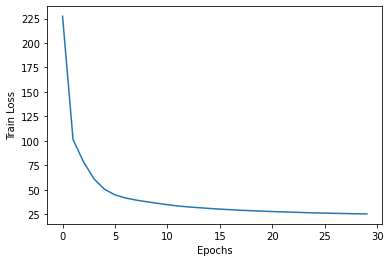

In [145]:
plt.ion() #Turn the interactive mode on
fig = plt.figure()
epochs = list(range(30))
plt.plot(epochs,train_loss_sum)
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.show()

In [147]:
torch.save(model.state_dict(), "./model_checkpoints/gat_64_hid64_infeats12.pth")

RuntimeError: cuda runtime error (719) : unspecified launch failure at /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/generic/serialization.cpp:31

In [24]:
gcn_model = GCN(in_feats=4, hid_feats=32, out_feats=2).to(dev)
gat_model = My_GAT(input_dim=4, hidden_dim=32, output_dim=2).to(dev)
gat_model.load_state_dict(torch.load('./model_checkpoints/gat_15batches_vblesize.pth'))
gcn_model.load_state_dict(torch.load('./model_checkpoints/gcn_64_64_infeats12.pth'))
print(gcn_model)
print(gat_model)

GCN(
  (conv1): GCNLayer(
    (linear_self): Linear(in_features=4, out_features=32, bias=False)
    (linear): Linear(in_features=4, out_features=32, bias=True)
  )
  (conv2): GCNLayer(
    (linear_self): Linear(in_features=32, out_features=2, bias=False)
    (linear): Linear(in_features=32, out_features=2, bias=True)
  )
  (fc): Linear(in_features=2, out_features=2, bias=True)
)
My_GAT(
  (embedding_h): Linear(in_features=4, out_features=32, bias=True)
  (gat_1): My_GATLayer(
    (linear_self): Linear(in_features=32, out_features=32, bias=False)
    (linear_func): Linear(in_features=32, out_features=32, bias=False)
    (attention_func): Linear(in_features=64, out_features=1, bias=False)
  )
  (gat_2): My_GATLayer(
    (linear_self): Linear(in_features=32, out_features=32, bias=False)
    (linear_func): Linear(in_features=32, out_features=32, bias=False)
    (attention_func): Linear(in_features=64, out_features=1, bias=False)
  )
  (linear1): Linear(in_features=32, out_features=2, bias=

In [100]:
error_seg1=[]
error_seg2=[]
error_seg3=[]
error_per_frame=[]
with torch.no_grad():
    i = val_id_list[1]
    graph = dgl.from_scipy(spp.coo_matrix(adj[i][:last_vis_obj[i],:last_vis_obj[i]])).int().to(dev)
    snorm_n, snorm_e, norm_d = collate(graph)
    #graph = dgl.remove_self_loop(graph)
    #graph = dgl.add_self_loop(graph)
    distances = [xy_dist[i][graph.edges()[0][i]][graph.edges()[1][i]] for i in range(graph.num_edges())]
    norm_distances = [(i-min(distances))/(max(distances)-min(distances)) if (max(distances)-min(distances))!=0 else (i-min(distances))/1.0 for i in distances]
    norm_distances = [1/(i) if i!=0 else 1 for i in distances]
    e_w=torch.tensor(norm_distances, dtype=torch.float32).to(dev)

    features = node_features[i,:last_vis_obj[i]].to(dev)
    features = features.view(features.shape[0],-1)
    
    #forward prop by using all nodes
    pred = model(graph, features ,e_w,snorm_n, snorm_e)
    print(pred.shape)
    output_mask_i = output_mask[i,:last_vis_obj[i]].to(dev)
    
    pred=pred.view(pred.shape[0],6,-1)
    print(pred.shape, output_mask_i.shape)
    pred = pred*output_mask_i #Con esto ya quito del error aquellas filas donde no tengo datos.
    
    gt = node_labels[i,:last_vis_obj[i]].to(dev)
    gt = gt*output_mask_i  #BV,T,C
    
    
    x2y2_error=torch.sum(torch.abs(pred-gt)**2,dim=-1)  #x²+y²
    xy_error=torch.sum(x2y2_error**0.5, dim=0).detach().cpu().numpy()  #raiz(x²+y²)   Error en cada frame
    overall_num= output_mask_i.detach().cpu().numpy().sum(axis=-1).sum(axis=0) #numero de agentes en cada frame
    
    error_per_frame.append(xy_error / overall_num)
    error_seg1.append(error_per_frame[:2])
    error_seg2.append(error_per_frame[2:4])
    error_seg3.append(error_per_frame[4:])
    
print(xy_error,overall_num,error_per_frame)

torch.Size([11, 12])
torch.Size([11, 6, 2]) torch.Size([11, 6, 1])
[ 6.97032039 16.24366518 25.18899576 37.90354284 50.05630499 61.99487009] [3. 3. 3. 3. 3. 3.] [array([ 2.32344013,  5.41455506,  8.39633192, 12.63451428, 16.685435  ,
       20.6649567 ])]


### TEST

In [112]:
model.eval()
xy_s1_list= []
xy_s2_list= []
xy_s3_list= []
num_s1_list= []
num_s2_list= []
num_s3_list= []
with torch.no_grad():

    for batched_graph, output_masks,snorm_n, snorm_e,last_vis_obj in tqdm(val_dataloader):
        feats = batched_graph.ndata['x'].float().to(dev)
        feats = feats.view(feats.shape[0],-1)
        e_w = batched_graph.edata['w'].float().to(dev)
        labels= batched_graph.ndata['gt'].float().to(dev)
        pred = model(batched_graph, feats,e_w,snorm_n,snorm_e)
        _, overall_num, x2y2_error = compute_RMSE_batch(pred, labels, output_masks)
        xy_error = (x2y2_error**0.5).detach().cpu().numpy() #BV,T
        overall_num = overall_num.detach().cpu().numpy()
        xy_s1_list.extend(xy_error[:,:2])
        xy_s2_list.extend(xy_error[:,2:4])
        xy_s3_list.extend(xy_error[:,4:])
        num_s1_list.extend(overall_num[:,:2])
        num_s2_list.extend(overall_num[:,2:4])
        num_s3_list.extend(overall_num[:,4:])
        
                
overall_sum_s1=np.sum(xy_s1_list,axis=0)  #BV,T->T
overall_sum_s2=np.sum(xy_s2_list,axis=0)
overall_sum_s3=np.sum(xy_s3_list,axis=0)
overall_num_s1 =np.sum(num_s1_list, axis=0)
overall_num_s2 =np.sum(num_s2_list, axis=0)
overall_num_s3 =np.sum(num_s3_list, axis=0)
    
overall_loss_s1=(overall_sum_s1 / overall_num_s1)#media del error de cada agente en cada frame
overall_loss_s2=(overall_sum_s2 / overall_num_s2)
overall_loss_s3=(overall_sum_s3 / overall_num_s3)

print('Val_loss_sec1: average: {}'.format(overall_loss_s1))
print('Val_loss_sec2: average: {}'.format(overall_loss_s2))
print('Val_loss_sec3: average: {}'.format(overall_loss_s3))
      


100%|██████████| 919/919 [00:14<00:00, 65.06it/s]

Val_loss_sec1: average: [2.31441037 4.2413773 ]
Val_loss_sec2: average: [6.1609918  8.02109042]
Val_loss_sec3: average: [ 9.81330062 11.70142501]
